In [1]:
!pip install -q gdown torchmetrics lpips torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00


In [2]:
# getting neccesary files downloaded
import gdown
urls= [
    "https://drive.google.com/uc?id=1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8", # only_masked
    "https://drive.google.com/uc?id=1cBcNZvKiA19RS78yzUyg8KuFwbgictnO", # lama
    "https://drive.google.com/uc?id=1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS" # mat
      ]

for url in urls:
    gdown.download(url)

Downloading...
From (original): https://drive.google.com/uc?id=1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8
From (redirected): https://drive.google.com/uc?id=1u_nme6-H4SD7Pl1sJ0u9AWUjIQGRgFB8&confirm=t&uuid=3e2ac8b0-0c10-4f36-8080-fd50d14dc78d
To: /content/only_masked.zip
100%|██████████| 63.7M/63.7M [00:00<00:00, 80.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1cBcNZvKiA19RS78yzUyg8KuFwbgictnO
From (redirected): https://drive.google.com/uc?id=1cBcNZvKiA19RS78yzUyg8KuFwbgictnO&confirm=t&uuid=703c20ed-b01d-4e38-acb1-8d47fd655452
To: /content/lama.zip
100%|██████████| 340M/340M [00:07<00:00, 42.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS
From (redirected): https://drive.google.com/uc?id=1-1y31xO5KVNOYFgxNX2NIMGEEC6syYwS&confirm=t&uuid=fc4c4be7-f263-4547-85ae-f3c2d9ed98f3
To: /content/mat.zip
100%|██████████| 281M/281M [00:06<00:00, 44.9MB/s]


Cloning into 'Zero-DCE'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 236 (delta 43), reused 225 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (236/236), 30.89 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [3]:
#making the unzip function
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted all files to {extract_to}')

In [4]:
#usng the unzip function
unzip_file("lama.zip", "neww")
unzip_file("mat.zip", "neww")
unzip_file("only_masked.zip", "neww")

Extracted all files to neww
Extracted all files to neww
Extracted all files to neww


DONE!!


In [5]:
# downloading the dataset
import torchvision

train = torchvision.datasets.Places365(root = "data/", split = 'val', small = True, download = True )
train

100%|██████████| 67498496/67498496 [01:37<00:00, 690189.33it/s]


Extracting data/filelist_places365-standard.tar to data/


100%|██████████| 525158400/525158400 [01:05<00:00, 8045411.80it/s] 


Extracting data/val_256.tar to data/


Dataset Places365
    Number of datapoints: 36500
    Root location: data/
    Split: val
    Small: True

In [6]:
# reoving the wrong files
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

path = Path("data/val_256/")

# if we will use train data then it would have folders many of diff objects while in validation set there is no such complicaion
# removing the improper images
count = 0
for i in os.listdir(path):
  img = plt.imread(path/i)
  if img.shape[-1] != 3:
    os.remove(path/i)
    count += 1

print(f"Deleted images with incorrect number of dims : {count}")

Deleted images with incorrect number of dims : 79


In [7]:
# checking the number of each imgs
from pathlib import Path
import pandas as pd

path0 = Path("data/val_256/")
path = Path("neww/content/drive/MyDrive/LAMA_MAT/mat_test_images")
path2 = Path("neww/content/drive/MyDrive/LAMA_MAT/lama_test_images22")
path3 = Path("neww/content/only_masked")

l0 = list(path0.glob("*.jpg"))
l1 = list(path.glob("*.png"))
l2 = list(path2.glob("*.jpg"))
l3 = list(path3.glob("*.jpg"))

l0.sort()
l1.sort()
l2.sort()
l3.sort()
print(len(l0),len(l1), len(l2), len(l3))

36421 7527 22479 36421


In [8]:
# the custom dataset function
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
class inpainting_dataset(Dataset):
  """
  The path must be a PAthLib Path object
  """
  def __init__(self, path, transform = None, split : str = "train"):
    self.path = path
    self.transform = transform
    self.imgs =  list(self.path.glob("*.jpg"))

    self.path = Path("neww/content/drive/MyDrive/LAMA_MAT/lama_test_images22")
    self.lama_imgs = list(self.path.glob("*.jpg"))

    self.path = Path("neww/content/drive/MyDrive/LAMA_MAT/mat_test_images")
    self.mat_imgs = list(self.path.glob("*.png"))

    self.path = Path("neww/content/only_masked/")
    self.masks = list(self.path.glob("*.jpg"))

    self.final = []
    for i in self.imgs:
      name = i.as_posix().split("/")[-1].split(".")[0]
      mat_name = "neww/content/drive/MyDrive/LAMA_MAT/mat_test_images/" + name + ".png"    # for mat we have png format
      lama_name = "neww/content/drive/MyDrive/LAMA_MAT/lama_test_images22/" + name + ".jpg" # for lama we have jpg format
      mask_name = "neww/content/only_masked/" + name + ".jpg" # for masks

      if os.path.exists(mat_name) and os.path.exists(lama_name) and os.path.exists(mask_name):
        self.final.append(name)

    self.train_imgs, self.val_imgs = train_test_split(self.final, test_size = 0.3,random_state = 42)
    if split == "train":
      self.imgs = self.train_imgs
    else:
      self.imgs = self.val_imgs

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx): # self.final have onlyu names which will be used to just make the path of imgs
    name = self.imgs[idx]  # to get the path only

    img_n = "data/val_256/" + name + ".jpg"  # for image name
    mat = "neww/content/drive/MyDrive/LAMA_MAT/mat_test_images/" + name + ".png"    # for mat we have png format
    lama = "neww/content/drive/MyDrive/LAMA_MAT/lama_test_images22/" + name + ".jpg" # for lama we have jpg format
    mask = "neww/content/only_masked/" + name + ".jpg" # for masks

    img = cv2.imread(img_n)
    img_lama = torch.tensor(cv2.imread(lama))
    mat_img = cv2.imread(mat)

    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    _, binary_mk = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inv_mask = cv2.bitwise_not(binary_mk)

    img_back = cv2.bitwise_and(img, img, mask=inv_mask)
    img_fg = cv2.bitwise_and(mat_img, mat_img, mask=binary_mk)

    final_mat_img = img_back + img_fg

    return torch.tensor(img), img_lama, torch.tensor(final_mat_img) #i.e. correct image, lama and mat image

In [9]:
path = Path("data/val_256/")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [10]:
# making the train and test dataset
train_dataset = inpainting_dataset(path, transform = transform, split = "train")
test_dataset = inpainting_dataset(path, transform = transform, split = "test")
train_dataset, test_dataset

(<__main__.inpainting_dataset at 0x7f0484e49510>,
 <__main__.inpainting_dataset at 0x7f055224e0e0>)

In [11]:
# making the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16,shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f048a606bf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f048a606aa0>)

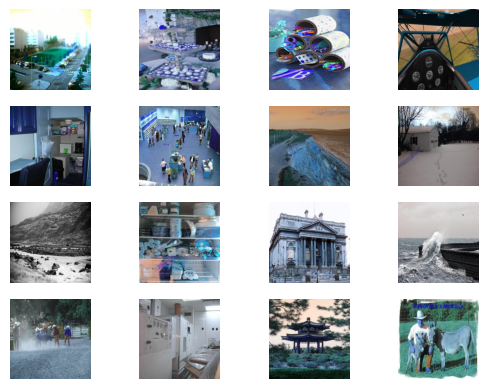

In [ ]:
# exploringg some data
z = next(iter(train_dataloader))

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(z[2][i].detach().numpy())

In [ ]:
# the ensemble model --- PLAIN ONE
import torch
from torch import nn

class EnsembleModel(nn.Module):
  """
  This model will combine the output MAT and LAMA which will be saved in the model folder
  """
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.ReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.ReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.ReLU(),
        # nn.MaxPool2d(2),
    )

    self.in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.ReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.ReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.ReLU(),
    )


  def forward(self, img1, img2):
    x = self.conv1(img1)
    y = self.conv2(img2)
    z = torch.cat((x, y), dim=1)
    z = self.conv3(z)
    z = self.in_conv3(z)
    return z


# MULTI SCALE ENSEMBLE

## 1 DIFF FEATURE MAP LEVEL

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

class MultiScaleImageSynthesis(nn.Module):
    def __init__(self):
        super(MultiScaleImageSynthesis, self).__init__()

        # Pretrained feature extractor (ResNet for feature extraction)
        self.feature_extractor = models.resnet18(pretrained=True)

        # Feature extraction at different scales (low, mid, high)
        self.layer1 = nn.Sequential(*list(self.feature_extractor.children())[:5]) # Low-level features
        self.layer2 = nn.Sequential(*list(self.feature_extractor.children())[5:6]) # Mid-level features
        self.layer3 = nn.Sequential(*list(self.feature_extractor.children())[6:][0])  # High-level features

        self.meow1 = nn.ConvTranspose2d(128, 256, kernel_size=3, padding=1)
        self.meow2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        # Fusion convolution layers for multi-scale combination
        self.conv_fusion1 = nn.Conv2d(768, 384, kernel_size=3, padding=1)  # 256(low) + 256(mid) + 256(high) = 768
        self.conv_fusion2 = nn.Conv2d(384, 192, kernel_size=3, padding=1)

        # Upsampling layers for final image synthesis
        self.up1 = nn.ConvTranspose2d(192, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)  # Output: RGB image

    def extract_features(self, x):
        # Extract features at multiple scales
        x_low = self.layer1(x)   # Low-level features
        x_mid = self.layer2(x_low)  # Mid-level features
        x_high = self.layer3(x_mid)  # High-level features
        return x_low, x_mid, x_high

    def forward(self, img1, img2):
        # t = transforms.Resize((16,16))
        # Extract multi-scale features from both images
        img1_low, img1_mid, img1_high = self.extract_features(img1)
        img2_low, img2_mid, img2_high = self.extract_features(img2)

        # Combine low, mid, and high-level features for both images
        combined_low = F.interpolate(torch.cat((img1_low, img2_low), dim=1), size = (16,16), mode = 'bilinear', align_corners = False)
        combined_mid = F.interpolate(torch.cat((img1_mid, img2_mid), dim=1), size = (16,16), mode = 'bilinear', align_corners = False)
        combined_high = F.interpolate(torch.cat((img1_high, img2_high), dim=1), size = (16,16), mode = 'bilinear', align_corners = False)
        combined_low = self.meow1(combined_low)
        combined_high = self.meow2(combined_high)
        # print(combined_low.shape, combined_mid.shape, combined_high.shape)

        # Concatenate features from all scales: low + mid + high
        combined_features = torch.cat((combined_low, combined_mid, combined_high), dim=1)

        # Pass through fusion layers
        combined_features = F.relu(self.conv_fusion1(combined_features))
        combined_features = F.relu(self.conv_fusion2(combined_features))

        # Upsample to synthesize final image
        output = F.relu(self.up1(combined_features))  # Upsample 1
        output = F.relu(self.up2(output))             # Upsample 2
        output = F.relu(self.up3(output))             # Upsample 3
        output = torch.sigmoid(self.up4(output))      # Final output: synthesized image

        return output

# Instantiate and test the model
model = MultiScaleImageSynthesis()

# Sample input images (dummy tensors representing two images)
img1 = torch.randn(1, 3, 256, 256)  # 1 image, 3 channels (RGB), 224x224 resolution
img2 = torch.randn(1, 3, 256, 256)

# Forward pass through the model to synthesize a new image
output_img = model(img1, img2)
print(output_img.shape)  # Expected output shape: (1, 3, 224, 224) for an RGB image


torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'final')

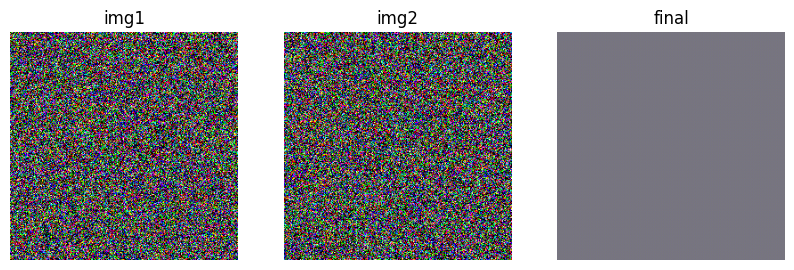

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img1.squeeze().permute(1,2,0).numpy())
plt.axis("off")
plt.title("img1")

plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(img2.squeeze().permute(1,2,0).numpy())
plt.title("img2")

plt.subplot(1,3,3)
plt.axis("off")
plt.imshow((output_img).squeeze().permute(1,2,0).detach().numpy())
plt.title("final")


In [ ]:
output_img

tensor([[[[0.5328, 0.5190, 0.5386,  ..., 0.5189, 0.5379, 0.5175],
          [0.5502, 0.5344, 0.5462,  ..., 0.5344, 0.5470, 0.5349],
          [0.5368, 0.5175, 0.5389,  ..., 0.5177, 0.5383, 0.5215],
          ...,
          [0.5497, 0.5349, 0.5465,  ..., 0.5347, 0.5463, 0.5350],
          [0.5380, 0.5177, 0.5392,  ..., 0.5176, 0.5392, 0.5221],
          [0.5464, 0.5359, 0.5469,  ..., 0.5354, 0.5478, 0.5321]],

         [[0.5430, 0.5197, 0.5431,  ..., 0.5196, 0.5432, 0.5184],
          [0.5324, 0.5305, 0.5297,  ..., 0.5306, 0.5295, 0.5305],
          [0.5418, 0.5193, 0.5452,  ..., 0.5198, 0.5445, 0.5224],
          ...,
          [0.5332, 0.5309, 0.5306,  ..., 0.5304, 0.5299, 0.5306],
          [0.5418, 0.5189, 0.5452,  ..., 0.5193, 0.5445, 0.5223],
          [0.5344, 0.5308, 0.5350,  ..., 0.5307, 0.5343, 0.5316]],

         [[0.4922, 0.4935, 0.4919,  ..., 0.4935, 0.4925, 0.4924],
          [0.4862, 0.4942, 0.4858,  ..., 0.4945, 0.4862, 0.4923],
          [0.4923, 0.4889, 0.4944,  ..., 0

## 2 Diff RESOLUTION LEVEL

In [12]:
# the ensemble model --- PLAIN ONE
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

class MultiScaleEnsembleModel_Res(nn.Module):
  """
  This model will combine the output MAT and LAMA which will be saved in the model folder
  """
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )

    self.in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
    )

    # FOR SMALL IMGS
    self.small_conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.ReLU(),
        # nn.MaxPool2d(2),
    )
    self.small_conv2 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.small_conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )

    self.small_in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
    )

    # FOR final IMGS
    self.f_conv1 = nn.Sequential(
        nn.Conv2d(6, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.f_conv3 = nn.Sequential(
        nn.Conv2d(32, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )

    self.f_in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
    )

  def forward(self, img1, img2): # lets just hardcode it for now
    x = self.conv1(img1)
    y = self.conv2(img2)
    z = torch.cat((x, y), dim=1)
    z = self.conv3(z)
    z = self.in_conv3(z)

    # small_img1 = transforms.Resize((128,128))(img1)
    # small_img2 = transforms.Resize((128,128))(img2)

    small_img1 = F.interpolate(img1, (128,128), mode = 'bilinear', align_corners=False)
    small_img2 = F.interpolate(img2, (128,128), mode = 'bilinear', align_corners=False)

    small_x = self.small_conv1(small_img1)
    small_y = self.small_conv2(small_img2)
    small_z = torch.cat((small_x, small_y), dim=1)
    small_z = self.small_conv3(small_z)
    small_z = self.small_in_conv3(small_z)
    # small_out = transforms.Resize((256,256))(small_z)
    small_out = F.interpolate(small_z, (256,256), mode = 'bilinear', align_corners=False)

    # so now we have 2 processed
    final_z = torch.cat((z, small_out), dim = 1)
    meow = self.f_conv1(final_z)
    meow = self.f_conv3(meow)
    meow = self.f_in_conv3(meow)

    return meow


In [13]:
# Instantiate and test the model
model = MultiScaleEnsembleModel_Res()

# Sample input images (dummy tensors representing two images)
img1 = torch.randn(1, 3, 256, 256)  # 1 image, 3 channels (RGB), 224x224 resolution
img2 = torch.randn(1, 3, 256, 256)

# Forward pass through the model to synthesize a new image
output_img = model(img1, img2)
print(output_img.shape)  # Expected output shape: (1, 3, 224, 224) for an RGB image


torch.Size([1, 3, 256, 256])


Text(0.5, 1.0, 'final')

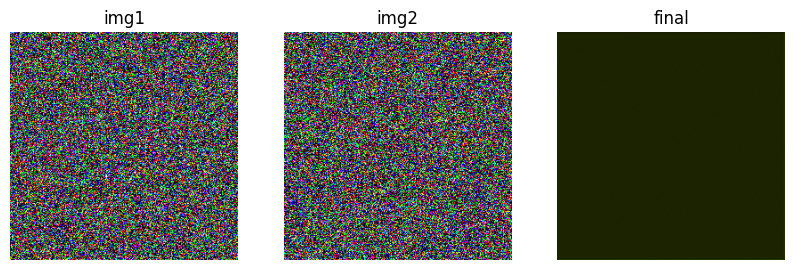

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(img1.squeeze().permute(1,2,0).numpy())
plt.axis("off")
plt.title("img1")

plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(img2.squeeze().permute(1,2,0).numpy())
plt.title("img2")

plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(output_img.squeeze().permute(1,2,0).detach().numpy())
plt.title("final")


In [ ]:
output_img[0]

tensor([[[ 0.1244,  0.0891,  0.0972,  ...,  0.0912,  0.0859,  0.1232],
         [ 0.1234,  0.1024,  0.1122,  ...,  0.1066,  0.1079,  0.1455],
         [ 0.1187,  0.0937,  0.1037,  ...,  0.1002,  0.1093,  0.1487],
         ...,
         [ 0.1281,  0.0980,  0.1073,  ...,  0.1053,  0.1111,  0.1493],
         [ 0.1194,  0.0804,  0.0866,  ...,  0.0816,  0.0972,  0.1341],
         [ 0.1231,  0.1145,  0.1192,  ...,  0.1229,  0.1368,  0.1586]],

        [[ 0.0824,  0.1147,  0.1084,  ...,  0.1073,  0.1259,  0.1698],
         [ 0.1128,  0.1418,  0.1254,  ...,  0.1223,  0.1465,  0.1707],
         [ 0.1186,  0.1489,  0.1294,  ...,  0.1323,  0.1527,  0.1719],
         ...,
         [ 0.1179,  0.1566,  0.1364,  ...,  0.1363,  0.1590,  0.1699],
         [ 0.1090,  0.1473,  0.1327,  ...,  0.1342,  0.1533,  0.1738],
         [ 0.1874,  0.2187,  0.2179,  ...,  0.2220,  0.2267,  0.2047]],

        [[-0.0014, -0.0014, -0.0012,  ..., -0.0012, -0.0012, -0.0014],
         [-0.0012, -0.0011, -0.0010,  ..., -0

# LOSS Fn

In [14]:
# the loss function utility
import os
import torch
from collections import OrderedDict
from torch import nn as nn
from torchvision.models import vgg as vgg

class Registry():
    """
    The registry that provides name -> object mapping, to support third-party
    users' custom modules.

    To create a registry (e.g. a backbone registry):

    .. code-block:: python

        BACKBONE_REGISTRY = Registry('BACKBONE')

    To register an object:

    .. code-block:: python

        @BACKBONE_REGISTRY.register()
        class MyBackbone():
            ...

    Or:

    .. code-block:: python

        BACKBONE_REGISTRY.register(MyBackbone)
    """

    def __init__(self, name):
        """
        Args:
            name (str): the name of this registry
        """
        self._name = name
        self._obj_map = {}

    def _do_register(self, name, obj):
        assert (name not in self._obj_map), (f"An object named '{name}' was already registered "
                                             f"in '{self._name}' registry!")
        self._obj_map[name] = obj

    def register(self, obj=None):
        """
        Register the given object under the the name `obj.__name__`.
        Can be used as either a decorator or not.
        See docstring of this class for usage.
        """
        if obj is None:
            # used as a decorator
            def deco(func_or_class):
                name = func_or_class.__name__
                self._do_register(name, func_or_class)
                return func_or_class

            return deco

        # used as a function call
        name = obj.__name__
        self._do_register(name, obj)

    def get(self, name):
        ret = self._obj_map.get(name)
        if ret is None:
            raise KeyError(f"No object named '{name}' found in '{self._name}' registry!")
        return ret

    def __contains__(self, name):
        return name in self._obj_map

    def __iter__(self):
        return iter(self._obj_map.items())

    def keys(self):
        return self._obj_map.keys()


DATASET_REGISTRY = Registry('dataset')
ARCH_REGISTRY = Registry('arch')
MODEL_REGISTRY = Registry('model')
LOSS_REGISTRY = Registry('loss')
METRIC_REGISTRY = Registry('metric')

VGG_PRETRAIN_PATH = 'experiments/pretrained_models/vgg19-dcbb9e9d.pth'
NAMES = {
    'vgg11': [
        'conv1_1', 'relu1_1', 'pool1', 'conv2_1', 'relu2_1', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
        'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2',
        'pool5'
    ],
    'vgg13': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'pool5'
    ],
    'vgg16': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2',
        'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3',
        'pool5'
    ],
    'vgg19': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1',
        'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1',
        'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    ]
}


def insert_bn(names):
    """Insert bn layer after each conv.

    Args:
        names (list): The list of layer names.

    Returns:
        list: The list of layer names with bn layers.
    """
    names_bn = []
    for name in names:
        names_bn.append(name)
        if 'conv' in name:
            position = name.replace('conv', '')
            names_bn.append('bn' + position)
    return names_bn


@ARCH_REGISTRY.register()
class VGGFeatureExtractor(nn.Module):
    """VGG network for feature extraction.

    In this implementation, we allow users to choose whether use normalization
    in the input feature and the type of vgg network. Note that the pretrained
    path must fit the vgg type.

    Args:
        layer_name_list (list[str]): Forward function returns the corresponding
            features according to the layer_name_list.
            Example: {'relu1_1', 'relu2_1', 'relu3_1'}.
        vgg_type (str): Set the type of vgg network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize the input image. Importantly,
            the input feature must in the range [0, 1]. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        requires_grad (bool): If true, the parameters of VGG network will be
            optimized. Default: False.
        remove_pooling (bool): If true, the max pooling operations in VGG net
            will be removed. Default: False.
        pooling_stride (int): The stride of max pooling operation. Default: 2.
    """

    def __init__(self,
                 layer_name_list,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 requires_grad=False,
                 remove_pooling=False,
                 pooling_stride=2):
        super(VGGFeatureExtractor, self).__init__()

        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        self.names = NAMES[vgg_type.replace('_bn', '')]
        if 'bn' in vgg_type:
            self.names = insert_bn(self.names)

        # only borrow layers that will be used to avoid unused params
        max_idx = 0
        for v in layer_name_list:
            idx = self.names.index(v)
            if idx > max_idx:
                max_idx = idx

        if os.path.exists(VGG_PRETRAIN_PATH):
            vgg_net = getattr(vgg, vgg_type)(pretrained=False)
            state_dict = torch.load(VGG_PRETRAIN_PATH, map_location=lambda storage, loc: storage)
            vgg_net.load_state_dict(state_dict)
        else:
            vgg_net = getattr(vgg, vgg_type)(pretrained=True)

        features = vgg_net.features[:max_idx + 1]

        modified_net = OrderedDict()
        for k, v in zip(self.names, features):
            if 'pool' in k:
                # if remove_pooling is true, pooling operation will be removed
                if remove_pooling:
                    continue
                else:
                    # in some cases, we may want to change the default stride
                    modified_net[k] = nn.MaxPool2d(kernel_size=2, stride=pooling_stride)
            else:
                modified_net[k] = v

        self.vgg_net = nn.Sequential(modified_net).to(device)

        if not requires_grad:
            self.vgg_net.eval()
            for param in self.parameters():
                param.requires_grad = False
        else:
            self.vgg_net.train()
            for param in self.parameters():
                param.requires_grad = True

        if self.use_input_norm:
            # the mean is for image with range [0, 1]
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device))
            # the std is for image with range [0, 1]
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device))

    def forward(self, x):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        if self.range_norm:
            x = (x + 1) / 2
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = {}

        for key, layer in self.vgg_net._modules.items():
            x = layer(x)
            if key in self.layer_name_list:
                output[key] = x.clone()

        return output

In [15]:
# actual loss function
import torch.nn.functional as F

class StyleLoss(nn.Module):

    def __init__(self):
        super(StyleLoss, self).__init__()

    def gram_matrix(self,input):
      a, b, c, d = input.size()  # a=batch size(=1)
      # b=number of feature maps
      # (c,d)=dimensions of a f. map (N=c*d)

      features = input.contiguous().view(a * b, c * d)  # resize F_XL into \hat F_XL

      G = torch.mm(features, features.t())  # compute the gram product

      # we 'normalize' the values of the gram matrix
      # by dividing by the number of element in each feature maps.
      return G.div(a * b * c * d)

    def forward(self, input, target1):
        G = self.gram_matrix(input)
        target = self.gram_matrix(target1).detach()
        self.loss = F.mse_loss(G, target)
        return self.loss

class PerceptualLoss(nn.Module):
    """Perceptual loss with commonly used style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
            Here is an example: {'conv5_4': 1.}, which means the conv5_4
            feature layer (before relu5_4) will be extracted with weight
            1.0 in calculting losses.
        vgg_type (str): The type of vgg network used as feature extractor.
            Default: 'vgg19'.
        use_input_norm (bool):  If True, normalize the input image in vgg.
            Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
      """

    def __init__(self,
                 layer_weights = {'conv1_2': 1, 'conv2_2': 1,'conv3_4': 1,'conv4_4': 1},
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=True):
        super(PerceptualLoss, self).__init__()
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(self.layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm)

        self.criterion = torch.nn.L1Loss()

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        percep_loss = 0
        for k in x_features.keys():
            percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]

        return percep_loss


# def l1_loss():   -> take direct from premade
#   pass

class EdgeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1).to(device)

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)
        down        = filtered[:,:,::2,::2]
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4
        filtered    = self.conv_gauss(new_filter)
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = F.mse_loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, device = "cpu"):
        super(CombinedLoss, self).__init__()
        self.edge_loss = EdgeLoss().to(device)
        self.mse_loss = nn.MSELoss().to(device)  # l1 loss
        self.style_loss = StyleLoss().to(device)
        self.perceptual_loss = PerceptualLoss().to(device)

    def forward(self, gen_img, gt_img):
        gen_img.to(device)
        gt_img.to(device)
        edge_loss_value = self.edge_loss(gen_img, gt_img)
        mse_loss_value = self.mse_loss(gen_img, gt_img)
        style_loss_value = self.style_loss(gen_img, gt_img)
        perceptual_loss_value = self.perceptual_loss(gen_img, gt_img)
        total_loss = edge_loss_value + mse_loss_value + style_loss_value + perceptual_loss_value
        return total_loss


#TRAIINING

In [16]:
# training hyperparams
# OPTIMZER AND OTHER SETTINGS FOR TRAINING
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = CombinedLoss(device = device).to(device)
# rgb_to_hvi = RGB_HVI() another possibilty for modification

# model = EnsembleModel()
model = MultiScaleEnsembleModel_Res()
# model = MultiScaleImageSynthesis()
# model =torch.load("model.pth").to(device)
optimizer = Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.0MB/s]


In [26]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

model.to(device)

print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = model(lama, mat)

    loss = loss_fn(pred*255.0, img)  # for RGB color space
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = model(lama, mat)
      loss = loss_fn(pred*255.0, img)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(model, f"model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

# epoch : 4 || train loss : 403.2896171755907 || test loss : 462.86290255459875

<class '__main__.MultiScaleEnsembleModel_Res'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 359.4950795243426 || test loss : 491.28589456731623


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 373.4817311356707 || test loss : 286.2060872858221


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 667.5896402498571 || test loss : 515.6007381786


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 588.5907149152058 || test loss : 322.51439181241125


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 267.32820360137197 || test loss : 238.384746204723


In [27]:
# saving the final modelepoch : 4 || train loss : 267.32820360137197 || test loss : 238.384746204723
torch.save(model, "bagging_lama_mat_feature_resolution_level_fusion_model_alot_epochs.pth")

In [ ]:
loss_fn(pred, img)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
loss_fn(pred*255.0, img)

tensor(1120928.2500, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
z = next(iter(test_dataloader))
gt, lama, mat = z[0][0], z[1][0], z[2][0]

model.to("cpu")
pred = model(lama.unsqueeze(0).to(torch.float).permute(0,3,1,2), mat.unsqueeze(0).to(torch.float).permute(0,3,1,2)).squeeze()
pred.shape


torch.Size([3, 256, 256])

Text(0.5, 1.0, 'Prediction')

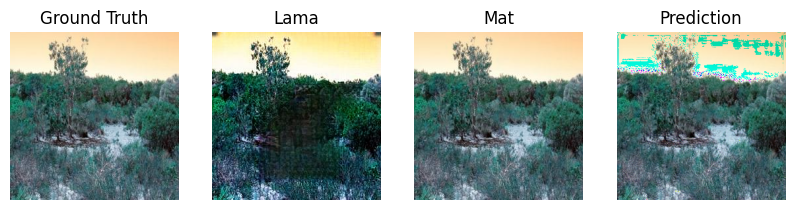

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow((gt).detach().numpy())
plt.axis("off")
plt.title("Ground Truth")

plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(lama.detach().numpy())
plt.title("Lama")

plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(mat.detach().numpy())
plt.title("Mat")

plt.subplot(1,4,4)
plt.axis("off")
plt.imshow((pred*255.0).to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("Prediction")

In [ ]:
pred

tensor([[[0.8421, 0.8802, 0.8355,  ..., 0.8797, 0.8669, 0.8651],
         [0.8214, 0.8406, 0.8589,  ..., 0.7553, 0.8498, 0.8297],
         [0.8875, 0.8045, 0.8967,  ..., 0.8214, 0.8172, 0.8212],
         ...,
         [0.3595, 0.3639, 0.3530,  ..., 0.3824, 0.3825, 0.3879],
         [0.3569, 0.3789, 0.3746,  ..., 0.3717, 0.3799, 0.3772],
         [0.3830, 0.3641, 0.3740,  ..., 0.3779, 0.3893, 0.3683]],

        [[0.7308, 0.7395, 0.7710,  ..., 0.6985, 0.6929, 0.6860],
         [0.7353, 0.7942, 0.7506,  ..., 0.6807, 0.7503, 0.7010],
         [0.7106, 0.7621, 0.7362,  ..., 0.7209, 0.6574, 0.7396],
         ...,
         [0.3933, 0.3918, 0.4104,  ..., 0.4239, 0.4278, 0.4065],
         [0.3911, 0.3863, 0.3974,  ..., 0.4253, 0.4356, 0.4329],
         [0.3828, 0.3886, 0.4118,  ..., 0.4312, 0.4365, 0.4181]],

        [[0.7342, 0.5434, 0.6247,  ..., 0.5888, 0.5558, 0.5559],
         [0.6330, 0.6233, 0.6212,  ..., 0.5386, 0.5022, 0.5832],
         [0.5895, 0.6444, 0.6183,  ..., 0.5609, 0.6394, 0.

In [ ]:
gt/255

tensor([[[0.9882, 0.8588, 0.6784],
         [0.9882, 0.8588, 0.6784],
         [0.9882, 0.8588, 0.6784],
         ...,
         [0.9843, 0.7882, 0.5608],
         [0.9843, 0.7882, 0.5608],
         [0.9843, 0.7882, 0.5608]],

        [[0.9882, 0.8588, 0.6784],
         [0.9882, 0.8588, 0.6784],
         [0.9882, 0.8588, 0.6784],
         ...,
         [0.9843, 0.7882, 0.5608],
         [0.9843, 0.7882, 0.5608],
         [0.9843, 0.7882, 0.5608]],

        [[0.9922, 0.8627, 0.6824],
         [0.9922, 0.8627, 0.6824],
         [0.9922, 0.8627, 0.6824],
         ...,
         [0.9882, 0.7922, 0.5647],
         [0.9882, 0.7922, 0.5647],
         [0.9882, 0.7922, 0.5647]],

        ...,

        [[0.0980, 0.1804, 0.2118],
         [0.1020, 0.2039, 0.2314],
         [0.2902, 0.4275, 0.4431],
         ...,
         [0.3294, 0.4392, 0.4667],
         [0.2549, 0.3569, 0.4039],
         [0.2627, 0.3647, 0.4118]],

        [[0.1333, 0.2353, 0.2627],
         [0.0784, 0.1922, 0.2196],
         [0.

In [31]:
# saving the final model
torch.save(model, "bagging_lama_mat_feature_map_level_fusion_model.pth")

In [ ]:
# starting the evaluation -- downloadng the pre trained weights if needed
gdrive.download("https://drive.google.com/uc?id=1y_NHh99laS2cx3_RtjqpgfIRAunak00I")

In [ ]:
# moving the file to accurate place
!mv Zero-DCE/Zero-DCE_code/model.py zero_model.py

In [ ]:
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


In [30]:
# finally evaluating the thing
import lpips
from tqdm import tqdm
import numpy as np
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
import os
import torch
# from zero_model import enhance_net_nopool
from torchvision.utils import save_image
# from loguru import logger

# logger.add("app.log")


def eval_model(model_, device, test_dataloader, out_dir):
    metric_fn = lpips.LPIPS(net='alex').to(device)

    # model = HINT(experiment=args.experiment) #calling a model
    model_ = model_.to(device) #puting in gpu
    # model.load_state_dict(torch.load(args.checkpoint_path, map_location=device)) #loading weights

    #get dataloader
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    fid = FrechetInceptionDistance().to(device)

    metric = 0
    ssim_metric = 0
    fid_metric = 0
    metric_list = []
    ssim_metric_list = []
    fid_metric_list = []

    # DCE_net = enhance_net_nopool().to(device)
    # DCE_net.load_state_dict(torch.load('Zero-DCE/Zero-DCE_code/snapshots/Epoch99.pth'))
    model_.eval()
    # DCE_net.eval()

    if not os.path.exists(out_dir):
        # Create a new directory because it does not exist
        os.makedirs(out_dir)

    with tqdm(total=len(test_dataloader), unit_scale=True, postfix={'lpips':0.0,'ssim':0.0, 'fid':0.0}, ncols=150) as pbar:
        for i, (img, lama, mat) in enumerate(test_dataloader):
            img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)
            gt_image = img

            with torch.no_grad():
                image_reconstructed = model_(lama, mat) # i need to do /255.0
                # the below lines are for using ZERO-DCE
                # _,image_reconstructed,_ = DCE_net(image_reconstructed/255.0)
                # image_reconstructed = image_reconstructed*255

            for j in range(image_reconstructed.shape[0]):
                x = image_reconstructed
                save_image(x[j], out_dir+'/'+ str((2*i)+j) + ".jpg" )


            ssim_metric += ssim(image_reconstructed, gt_image).item()
            fid.update(torch.tensor(image_reconstructed, dtype=torch.uint8), real = False)
            fid.update(torch.tensor(gt_image, dtype=torch.uint8), real = True)
            fid_metric += fid.compute().item()

            metric += torch.mean(metric_fn(gt_image, image_reconstructed)).item()
            metric_list.append(torch.mean(metric_fn(gt_image, image_reconstructed)).item())
            ssim_metric_list.append(ssim(image_reconstructed, gt_image).item())
            fid_metric_list.append(fid.compute().item())

            pbar.set_postfix({'lpips':metric/(i+1), 'ssim':ssim_metric/(i+1), 'fid' : fid_metric/(i+1)})
            pbar.update(1)

    print('\nLPIPS mean:', np.mean(metric_list))
    print('LPIPS std:', np.std(metric_list))
    print('ssim mean:', np.mean(ssim_metric_list))
    print('ssim std:', np.std(ssim_metric_list))
    print('fid mean:', np.mean(fid_metric_list))
    print('fid std:', np.std(fid_metric_list))

    return metric_list, ssim_metric_list, fid_metric_list

# m = EnsembleModel()
# model2 = torch.load("bagging_lama_mat_model.pth")
# model2 = m.load_state_dict(ldict)

device = 'cuda' if torch.cuda.is_available else "cpu"
metric_list, ssim_metric_list, fid_metric_list = eval_model(model, device, test_dataloader, "outputs")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


  0%|                                                                                             | 0.00/88.0 [00:00<?, ?it/s, fid=0, lpips=0, ssim=0]<ipython-input-30-2f68d10475a7>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(image_reconstructed, dtype=torch.uint8), real = False)
<ipython-input-30-2f68d10475a7>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(gt_image, dtype=torch.uint8), real = True)
 89%|█████████████████████████████████████████████████████████████████▌        | 78.0/88.0 [10:37<01:21, 8.17s/it, lpips=0.603, ssim=0.00208, fid=617]


KeyboardInterrupt: 

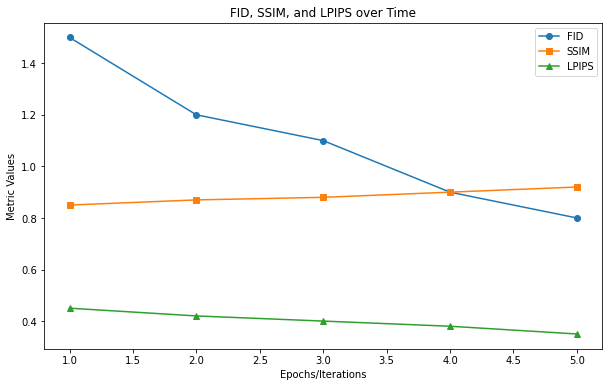

In [ ]:
# plotting the losses
import matplotlib.pyplot as plt

# Example data
fid_values = fid_metric_list
ssim_values = ssim_metric_list
lpips_values = metric_list

# X-axis values (e.g., epochs or iteration numbers)
x_values = list(range(1, len(fid_values) + 1))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(x_values, fid_values, label='FID', marker='o')

# Plot SSIM values
plt.plot(x_values, ssim_values, label='SSIM', marker='s')

# Plot LPIPS values
plt.plot(x_values, lpips_values, label='LPIPS', marker='^')

# Add labels and title
plt.xlabel('Epochs/Iterations')
plt.ylabel('Metric Values')
plt.title('FID, SSIM, and LPIPS over Time')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# for plotting the imgs
from zero_model import enhance_net_nopool

model_ =  torch.load("bagging_lama_mat_model.pth")
device = "cuda"
model_.to(device)
DCE_net = enhance_net_nopool().to(device)
DCE_net.load_state_dict(torch.load('Zero-DCE/Zero-DCE_code/snapshots/Epoch99.pth'))
model_.eval()
DCE_net.eval()

for i, (img, lama, mat) in enumerate(test_dataloader):
        img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)
        gt_image = img
        image_reconstructed = model_(lama, mat) # i need to do /255.0
        _,image_reconstructed2,_ = DCE_net(image_reconstructed/255.0)
        break

        # image_reconstructed = image_reconstructed*255

In [ ]:
num = 5
plt.figure(figsize=(10,10))
plt.subplot(1,5,1)
plt.imshow(img[num].to(torch.uint8).cpu().permute(1,2,0).detach().numpy())
plt.axis("off")
plt.title("Ground Truth")

plt.subplot(1,5,2)
plt.axis("off")
plt.imshow(lama[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("Lama")

plt.subplot(1,5,3)
plt.axis("off")
plt.imshow(mat[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("Mat")

plt.subplot(1,5,4)
plt.axis("off")
plt.imshow(image_reconstructed[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("No ZERO-DCE")

plt.subplot(1,5,5)
plt.axis("off")
plt.imshow((image_reconstructed2[num] * 255).cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("With ZERO-DCE")